In [1]:
import os

#Change working directory to /Users/albertvong/Documents/Argonne/PtychoPINN/
os.chdir('/home/av_linux/PtychoPINN')

In [2]:
import numpy as np
import importlib

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from tensordict import TensorDict

import lightning as L
import mlflow.pytorch
from mlflow import MlflowClient

from ptycho_torch.dset_loader_pt_mmap import PtychoDataset
from ptycho_torch.model import PtychoPINN

import matplotlib.pyplot as plt

from ptycho_torch.config_params import TrainingConfig, DataConfig, ModelConfig

/root/miniconda3/envs/ptychopinn_ptychodus_pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_config_default = {
    'nphotons': 1e5,
    'N': 128,
    'C': 4,
    'K': 6,
    'n_subsample': 10,
    'grid_size': (2,2),
    'probe_dir_get': True,
}


model_config_default = {
    'intensity_scale_trainable': True,
    'max_position_jitter': 10, #Random jitter for translation (helps make model more robust)
    'n_filters_scale': 2, #Shrinking factor for channels
    'intensity_scale': 15000.0, #General intensity scale guess, this can be trainable. Needs to be float
    'object.big': False, #True if need patch reassembly
    'probe.big': True, #True if need patch reassembly
    'offset': 4,
    'loss_function': 'Poisson'
}

training_config_default = {
    'nll': True, #Negative log likelihood for loss function
    'device': 'cuda'
}

t_config, d_config, m_config = TrainingConfig(), DataConfig(), ModelConfig()

t_config.set_settings(training_config_default)
d_config.set_settings(data_config_default)
m_config.set_settings(model_config_default)

In this notebook we'll be testing the training of PtychoPINN in Pytorch.

First, we're going to generate a "fake" test dataset using data from /ptycho/datasets/Run1084_recon_postPC_

# Testing out datagen methods

In [4]:
import ptycho_torch.helper as hh
import ptycho_torch.datagen as dg
import importlib

importlib.reload(hh)

<module 'ptycho_torch.helper' from '/home/av_linux/PtychoPINN/ptycho_torch/helper.py'>

In [5]:
output = dg.simulate_from_npz('ptycho_torch/datasets/als128.npy.npz', 2000)

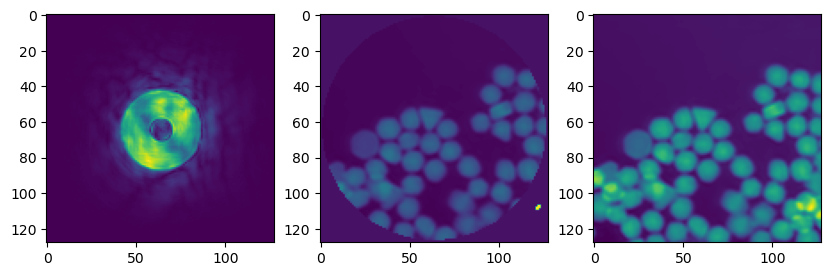

In [6]:
i = 10
_, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(output['diff3d'][i])
axs[1].imshow(np.angle(output['object'][i]))
axs[2].imshow(np.angle(output['original_object'][i]))


In [7]:
#Save output as npz file in similar location
np.savez('ptycho_torch/datasets/als128_generated.npy.npz',
         diff3d = output['diff3d'],
         obj_orig = output['original_object'],
         obj = output['object'],
         obj_scale_factor = output['obj_scale_factor'],
         diff_scale_factor = output['diff_scale_factor'],
         xcoords = output['xcoords'],
         ycoords = output['ycoords'],
         xcoords_start = output['xcoords_start'],
         ycoords_start = output['ycoords_start'])


# Testing out tensorloader and model throughput

In [4]:
import importlib
import ptycho_torch
importlib.reload(ptycho_torch.helper)
importlib.reload(ptycho_torch.dset_loader_pt_mmap)

<module 'ptycho_torch.dset_loader_pt_mmap' from '/home/av_linux/PtychoPINN/ptycho_torch/dset_loader_pt_mmap.py'>

In [5]:
from ptycho_torch.dset_loader_pt_mmap import TensorDictDataLoader
import ptycho_torch.helper as hh


In [11]:
#Setting probes

#Need better separation of params and configs... confusing
#Could separate into 
#1. Model 
#2. Training
#3. Data


dset_raw = np.load('ptycho_torch/datasets/als128.npy.npz')

probe = dset_raw['probeGuess'][None]
probe = torch.from_numpy(probe)

# d_config.add('probes', probe)

In [12]:
dset_sim = np.load('ptycho_torch/datasets/als128_generated.npy.npz')

In [10]:
test_dset = PtychoDataset('ptycho_torch/datasets/dummy_data_small', 'ptycho_torch/datasets/probes',remake_map = False)

['probe1.npz']
Existing map found. Loading memory-mapped data


## Testing training workflow without lightning

In [11]:
class Collate(nn.Module):
    def __init__(self, device = None):
        super().__init__()
        self.device = torch.device(device)
    def __call__(self, x):
        '''
        Moves tensor to RAM, and then to GPU.

        Inputs
        -------
        x: TensorDict
        '''
        #Move data from memory map to RAM
        if self.device.type == 'cuda':
            out = x.pin_memory()
        else: #cpu
            out = x
        #Then Ram to GPU
        if self.device:
            out = out.to(self.device)
        return out

In [12]:
#Loading dataloader with first batch

testloader = TensorDictDataLoader(test_dset, batch_size = 64,
                                  collate_fn = Collate(device = TrainingConfig().get('device')))
#Grab first iter from testloader
test_iter = next(iter(testloader))
#Move test_iter to gpu

#Setting different tensors for model input
# diff = test_iter[0]['images'].to('cuda')
# positions = test_iter[0]['coords_relative'].to('cuda')
# probe = test_iter[1].to('cuda')
# scaling = test_iter[2].to('cuda')


In [23]:
from tensordict import TensorDictBase

In [26]:
test_map = TensorDictBase.load_memmap(prefix='data/memmap')

In [27]:
test_map['coords_relative'][0]

MemoryMappedTensor([[[0., 0.]],

                    [[0., 0.]],

                    [[0., 0.]],

                    [[0., 0.]]])

In [15]:
test_iter[0]['coords_relative']

tensor([[[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[[0., 0.]],

         [[0., 0.]],

         [[0., 0.]],

         [[0., 0.]]],


        [[

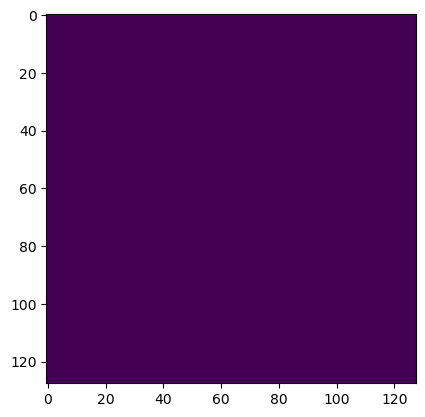

In [13]:
plt.imshow(test_iter[0]['images'][0,0])

In [39]:
model = PtychoPINN()
model.to('cuda')
model.training = True

In [40]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [41]:
#Testing a few iterations
n_iter = 20

for i in range(n_iter):
    test_iter = next(iter(testloader))
    #Move test_iter to gpu

    #Setting different tensors for model input
    diff = test_iter[0]['images'].to('cuda')
    positions = test_iter[0]['coords_relative'].to('cuda')
    probe = test_iter[1].to('cuda')
    scaling = test_iter[2].to('cuda')

    out = model(diff, positions, probe, scaling)
    loss = out.sum()
    print(f'Loss on iteration {i}: {loss}')

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 20)
    optimizer.step()

Loss on iteration 0: 1763150.25
Loss on iteration 1: 1588901.25
Loss on iteration 2: 1456865.5
Loss on iteration 3: 1361392.125
Loss on iteration 4: 1288737.25
Loss on iteration 5: 1231097.375
Loss on iteration 6: 1184039.625
Loss on iteration 7: 1145042.375
Loss on iteration 8: 1112821.5
Loss on iteration 9: 1086620.0
Loss on iteration 10: 1066057.875
Loss on iteration 11: 1050789.0
Loss on iteration 12: 1040240.3125
Loss on iteration 13: 1033430.25
Loss on iteration 14: 1029113.0
Loss on iteration 15: 1026176.375
Loss on iteration 16: 1024080.6875
Loss on iteration 17: 1022978.375
Loss on iteration 18: 1023442.3125
Loss on iteration 19: 1024745.875


In [35]:
model.forward_model.scaler.log_scale

Parameter containing:
tensor(9.6158, requires_grad=True)

Stepping through model (to make sure individual components work)

In [18]:
from ptycho_torch.model import Autoencoder, CombineComplex, ForwardModel, PoissonLoss, MAELoss

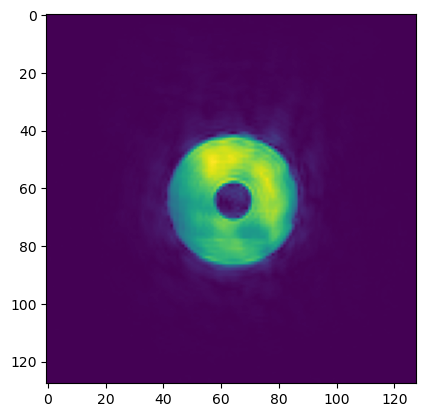

In [17]:
#Checking diffraction images
diff_1 = diff[0,3]

plt.imshow(diff_1.cpu())

In [65]:
n_filters_scale = 2
autoenc = Autoencoder(n_filters_scale)
autoenc.to('cuda')
autoenc_amp, autoenc_phase = autoenc(diff)

In [29]:
autoenc_phase.shape

torch.Size([64, 4, 128, 128])

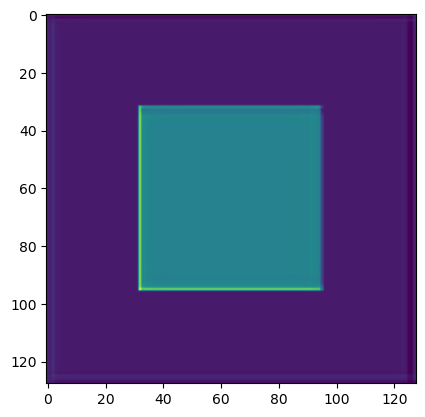

In [69]:
plt.imshow(autoenc_phase[3,0].detach().cpu())

In [70]:
combinecomplex = CombineComplex()
autoenc_combined = combinecomplex(autoenc_amp, autoenc_phase)

autoenc_combined.shape

torch.Size([64, 4, 128, 128])

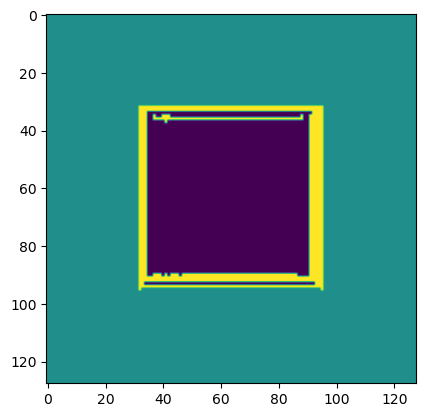

In [74]:
plt.imshow(autoenc_combined[0,3].detach().cpu().angle())

Reassemble patches

In [76]:
import ptycho_torch.helper as hh
from ptycho_torch.model import LambdaLayer

In [77]:
reassemble = LambdaLayer(hh.reassemble_patches_position_real)

In [80]:
positions[0].squeeze()

tensor([[ -6.8255,   8.7043],
        [  4.0697,   1.2832],
        [  9.5552,   3.2947],
        [ -6.7993, -13.2822]], device='cuda:0')

In [81]:
reassembled_out = reassemble(autoenc_combined, positions)

In [83]:
reassembled_out.shape

torch.Size([64, 142, 142])

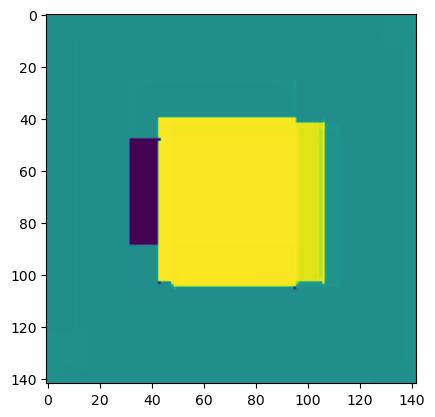

In [87]:
plt.imshow(reassembled_out[0].detach().cpu().angle())

In [88]:
test_complex_tensor = torch.complex(torch.randn(10, 10), torch.randn(10, 10))

test_complex_tensor[0,0]

tensor(0.8774+1.2504j)

In [89]:
test_complex_tensor[0,0], test_complex_tensor[0,0]/3

(tensor(0.8774+1.2504j), tensor(0.2925+0.4168j))